# Assignment 5

This assignment has weighting $1.5$.

# Model tuning and evaluation

In [2]:
# Added version check for recent scikit-learn 0.18 checks
from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version

## Dataset

We will use the Wisconsin breast cancer dataset for the following questions

In [3]:
import pandas as pd

wdbc_source = 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data'
#wdbc_source = '../datasets/wdbc/wdbc.data'

df = pd.read_csv(wdbc_source, header=None)

In [4]:
from sklearn.preprocessing import LabelEncoder
X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.transform(['M', 'B'])
#len(df.loc[0,2:])

array([1, 0], dtype=int32)

In [5]:
if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import train_test_split
else:
    from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.20, random_state=1)

In [5]:
%matplotlib inline

# K-fold validation (20 points)

Someone wrote the code below to conduct cross validation.
Do you see anything wrong with it?
And if so, correct the code and provide an explanation.

In [7]:
import numpy as np
import copy
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Perceptron
from sklearn.pipeline import Pipeline

if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import StratifiedKFold
else:
    from sklearn.model_selection import StratifiedKFold

scl = StandardScaler()
pca = PCA(n_components=2)
clf = Perceptron(random_state=1)

# data preprocessing
X_train_std = scl.fit_transform(X_train)
X_test_std = scl.transform(X_test)

X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

# compute the data indices for each fold
if Version(sklearn_version) < '0.18':
    kfold = StratifiedKFold(y=y_train, 
                            n_folds=10,
                            random_state=1)
else:
    kfold = StratifiedKFold(n_splits=10,
                            random_state=1).split(X_train, y_train)

num_epochs = 2
scores = []
#components = [2,3,4,5,6,7,8,9,10,11]
enumerate_kfold = list(enumerate(kfold))
for epoch in range(num_epochs):
    #pca=PCA(n_components=components[epoch])
    pipe_lr = Pipeline([('scl',scl),
                           ('pca',pca),
                           ('clf',clf)])
    for k, (train, test) in enumerate_kfold:
        pipe_lr.fit(X_train_std[train], y_train[train])
        score = pipe_lr.score(X_train_std[test], y_train[test])
        scores.append(score)
        print('Epoch: %s, Fold: %s, Class dist.: %s, Acc: %.3f' % (epoch,
                                                                   k, 
                                                                   np.bincount(y_train[train]),
                                                                   score))
    print('')
    
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))


Epoch: 0, Fold: 0, Class dist.: [256 153], Acc: 0.783
Epoch: 0, Fold: 1, Class dist.: [256 153], Acc: 0.717
Epoch: 0, Fold: 2, Class dist.: [256 153], Acc: 0.739
Epoch: 0, Fold: 3, Class dist.: [256 153], Acc: 0.674
Epoch: 0, Fold: 4, Class dist.: [256 153], Acc: 0.870
Epoch: 0, Fold: 5, Class dist.: [257 153], Acc: 1.000
Epoch: 0, Fold: 6, Class dist.: [257 153], Acc: 0.956
Epoch: 0, Fold: 7, Class dist.: [257 153], Acc: 0.933
Epoch: 0, Fold: 8, Class dist.: [257 153], Acc: 0.978
Epoch: 0, Fold: 9, Class dist.: [257 153], Acc: 0.978

Epoch: 1, Fold: 0, Class dist.: [256 153], Acc: 0.783
Epoch: 1, Fold: 1, Class dist.: [256 153], Acc: 0.717
Epoch: 1, Fold: 2, Class dist.: [256 153], Acc: 0.739
Epoch: 1, Fold: 3, Class dist.: [256 153], Acc: 0.674
Epoch: 1, Fold: 4, Class dist.: [256 153], Acc: 0.870
Epoch: 1, Fold: 5, Class dist.: [257 153], Acc: 1.000
Epoch: 1, Fold: 6, Class dist.: [257 153], Acc: 0.956
Epoch: 1, Fold: 7, Class dist.: [257 153], Acc: 0.933
Epoch: 1, Fold: 8, Class di

## Answer


First of all, we should initialize the classifier after each epoch to see whether the output is the same or not. We write the 

incorrect code if the output isn't the same. 

Secondly, we should use fit instead of partial_fit to train our classifier to avoid cumulative learning.

We use Pipeline method in sklearn to simplify our code.

# Precision-recall curve (40 points)

We have plotted ROC (receiver operator characteristics) curve for the breast cancer dataset.

Plot the precision-recall curve for the same data set using the same experimental setup.
What similarities and differences you can find between ROC and precision-recall curves?

You can find more information about precision-recall curve online such as: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html

# Answer

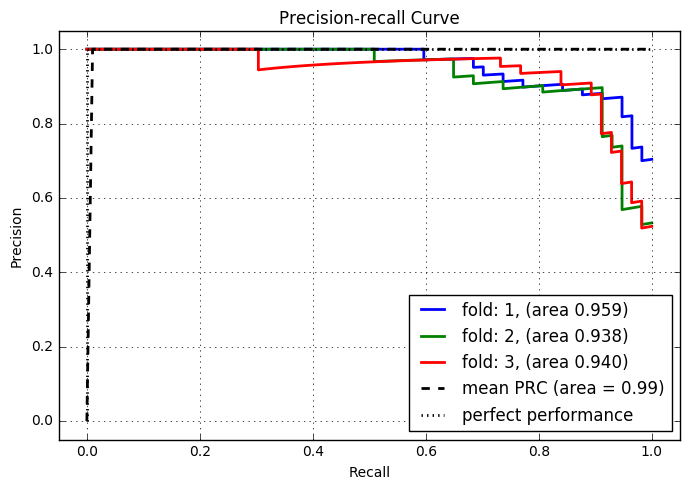

In [8]:
# your code
from sklearn.metrics import precision_recall_curve as prc
from sklearn.metrics import precision_score,recall_score
from sklearn.linear_model import LogisticRegression
from scipy import interp
from sklearn.metrics import auc
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

if sklearn_version < '0.18':
    from sklearn.cross_validation import StratifiedKFold
else:
    from sklearn.model_selection import StratifiedKFold

pipe_lr = Pipeline([('scl',StandardScaler()),
                    ('pca',PCA(n_components = 2)),
                    ('clf',LogisticRegression())])

X_train2 = X_train[:,4:14]
X_test2 = X_test[:,4:14]

cv = list(StratifiedKFold(n_splits = 3,
                           random_state = 1).split(X_train,y_train))

fig = plt.figure(figsize=(7,5))

mean_precision = 0
mean_recall= np.linspace(0,1,100)
all_precision = []

for i,(train,test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train],
                         y_train[train]).predict_proba(X_train2[test])
    precision, recall, threshold = prc(y_train[test]
                                     ,probas[:,1]
                                     ,pos_label = 1)
    
    mean_precision += interp(mean_recall,recall,precision)

    prc_auc = auc(recall,precision)
    
    plt.plot(recall,
             precision,
             lw = 2.0,
             label = 'fold: %d, (area %0.3f)'
                        % (i+1,prc_auc))
    
'''plt.plot([0,0],
         [1.0,1.0],
         linestyle = ':',
         lw = 2.0,
         color = 'blue',
         label = '45-degree line')'''

mean_precision /= len(cv)
mean_precision[0] = 0
mean_precision[-1] = 1
mean_auc = auc(mean_recall,mean_precision)
plt.plot(mean_recall,
         mean_precision,'k--',
         label = 'mean PRC (area = %0.2f)'% mean_auc, lw = 2.0)

plt.plot([0, 0, 1],
         [0, 1, 1],
         lw=2,
         linestyle=':',
         color='black',
         label='perfect performance')
    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-recall Curve')
plt.legend(loc="best")

plt.tight_layout()
# plt.savefig('./figures/roc.png', dpi=300)
plt.grid()
plt.show()

## your explanation
In Precision-recall curve, the Precision is $\frac{TP}{TP+FP}$,which represents the proportion of the relevance of selected 

items and the Recall is $\frac{TP}{TP+FN}$, which is the proportion that positive items are selected.

##### Differences: 
As shown in the two curve, Precision has a negative correlation with Recall in precision-recall curve 

while recall has a positive correlation with false positive rate in Receiver operating Characteristic.

#####  Similarities:
Both recall operating charateristic and precision-recall curve are used to approximate the practicality 

of classfiers. Under different situations, we choose either ROC or PRC or both to estimate our classifier. 

In general, the upper line represents the higher performance of classifier in both curve.



# Ensemble learning

We have used the following code to compute and plot the ensemble error from individual classifiers for binary classification:

In [138]:
from scipy.misc import comb
import math
import numpy as np

# Calculate the probability that the ensemble model makes mistakes.
def ensemble_error(num_classifier, base_error):
    k_start = math.ceil(num_classifier/2)
    probs = [comb(num_classifier, k)*(base_error**k)*((1-base_error)**(num_classifier-k)) for k in range(k_start, num_classifier+1)]
    return sum(probs)

In [139]:
import matplotlib.pyplot as plt
%matplotlib inline

In [140]:
def plot_base_error(ensemble_error_func, num_classifier, error_delta):

    error_range = np.arange(0.0, 1+error_delta, error_delta)
    ensemble_errors = [ensemble_error_func(num_classifier=num_classifier, base_error=error) for error in error_range]

    plt.plot(error_range, ensemble_errors, 
             label = 'ensemble error',
             linewidth=2)
    plt.plot(error_range, error_range,
             label = 'base error',
             linestyle = '--',
             linewidth=2)
    plt.xlabel('base error')
    plt.ylabel('base/ensemble error')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

In [141]:
num_classifier = 11
error_delta = 0.01
base_error = 0.25

In [142]:

print(ensemble_error(num_classifier=num_classifier, base_error=base_error))


0.034327507019


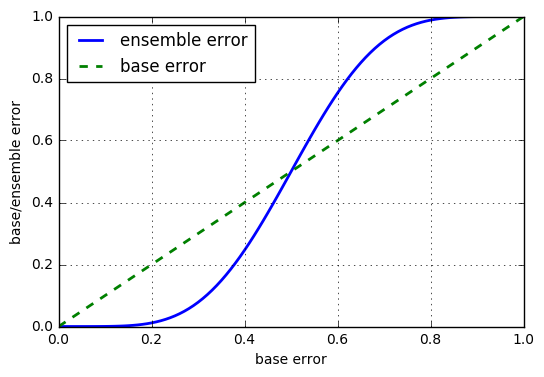

In [143]:
plot_base_error(ensemble_error, num_classifier=num_classifier, error_delta=error_delta)

# Number of classifiers (40 points)

The function plot_base_error() above plots the ensemble error as a function of the base error given a fixed number of classifiers.

Write another function to plot ensembe error versus different number of classifiers with a given base error.

Does the ensemble error always go down with more classifiers? 
Why or why not?

Can you improve the method ensemble_error() to produce a more reasonable plot?

## Answer

The code for plotting is below:

In [144]:
def plot_num_classifier(ensemble_error_func, max_num_classifier, base_error):
    # your code here
    num_classifiers = [i+1 for i in range(max_num_classifier)]
    Classifier_errors = [ensemble_error_func(num_classifier = i, base_error = base_error)
                            for i in num_classifiers]
    plt.scatter(num_classifiers,
             Classifier_errors,
             linestyle = '-',
             linewidth = 0.001,
             color = 'red')
    plt.plot(num_classifiers,
             Classifier_errors,
             linestyle = '-',
             color = 'blue' )
    plt.xlabel('NUM_OF_CLASSIFIERS')
    plt.ylabel('CLASSIFIER_ERRORS')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
    #pass

State your observations of the experiments of your code...

In [165]:
max_num_classifiers = 40
base_error = 0.4

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


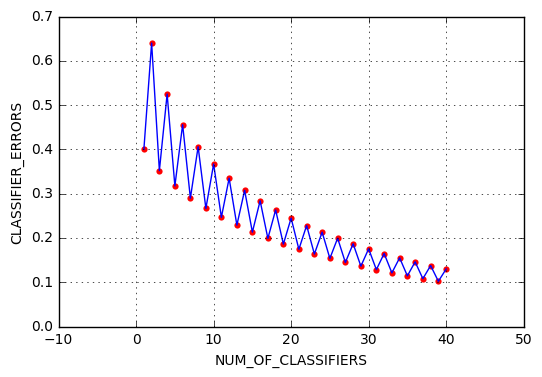

In [166]:
plot_num_classifier(ensemble_error, 
                    max_num_classifier=max_num_classifiers, 
                    base_error=base_error)

Explain your observations above.

Describe a better algorithm for computing the ensemble error.

### Obervations:
If base_error < 0.5, as the number of classifiers becomes large enough, the ensemble error will tend to zero. If base_error>0.5,

the ensemble error will tend to 1 as the number of classifiers becomes large. However, due to the feature of given ensemple

error algorithm, the graph will fluctuate heavily when the number of classifiers is not large and this will effect our experiment.  

i.e. 
$
\begin{align}
TotalError
&=
\sum_{\frac{n}{2}}^{n}{\binom{n}{k}*baseerror^k*(1-baseerror)^{n-k}}
\end{align}
$

The above function will fluctuate since it has some combination form.

#### Two ways to improve algorithm: 

Since we notice that when the base error is greater than 0.5, the more classifiers we use, the higher 

inaccuracy we get. So we may consider to choose different number of classifiers based on the base 

error.

$\large The\ first\ way$ is to use only one classifier if the base_error is larger than 0.5. After doing this simple judgement, we can 

optimize our ensemble error and produce more rational graph.

$\large The\ second\ way$ is to further choose the optimal number of classifiers to use from the range 1 to max_classifiers.

After the modification, we can eliminate the fluctuations of our graph and make it more rational and 

accurate. However, the computational efficiency is a bit lower.

Besides, when the number of classifiers which make right choices is equal to the number that make 

wrong choice, we have half probability to get right choices.

We provide three situations below: 

1. Consider the 0.5 threshold.

2. Don't consider the 0.5 threshold.

3. Choose optimal number of classifiers among maximum number of classifiers. 

#### 1. Include threshold:

In [229]:
def better_ensemble_error(num_classifier, base_error):
    if base_error > 0.5:
        return base_error
    else:
        k_start = math.ceil(num_classifier/2)
        k_start_floor = math.floor(num_classifier/2)
        #print("math.ceil(num_classifier/2): ",math.ceil(num_classifier/2))
        #print("math.floor(num_classifier/2): ",math.floor(num_classifier/2))
        #print("num_classifier/2: ",num_classifier/2)
        if num_classifier%2 == 0:
            probs = [comb(num_classifier, k)*(base_error**k)*((1-base_error)**(num_classifier-k)) for k in range(k_start+1, num_classifier+1)]
            probs.append(0.5*comb(num_classifier, k_start_floor)*(base_error**k_start_floor)*((1-base_error)**(num_classifier-k_start_floor)))
        else:
            probs = [comb(num_classifier, k)*(base_error**k)*((1-base_error)**(num_classifier-k)) for k in range(k_start, num_classifier+1)]
        return sum(probs)

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


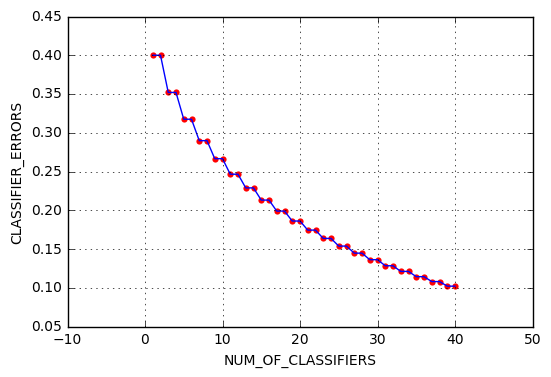

In [230]:
base_error = 0.4
plot_num_classifier(better_ensemble_error, 
                    max_num_classifier=max_num_classifiers, 
                    base_error=base_error)

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


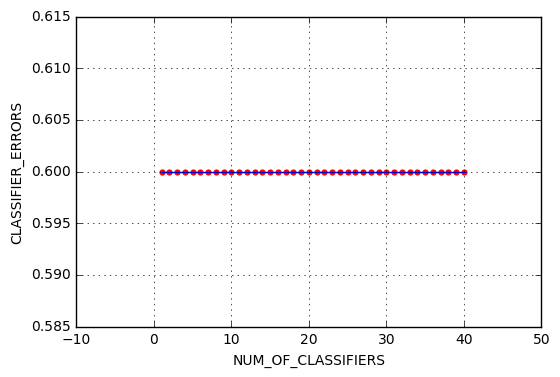

In [231]:
base_error = 0.6
plot_num_classifier(better_ensemble_error, 
                    max_num_classifier=max_num_classifiers, 
                    base_error=base_error)

#### Second way: Don't consider threshold to choose number of classifiers

In [232]:
def better_ensemble_error2(num_classifier, base_error):
    k_start = math.ceil(num_classifier/2)
    k_start_floor = math.floor(num_classifier/2)
    #print("math.ceil(num_classifier/2): ",math.ceil(num_classifier/2))
    #print("math.floor(num_classifier/2): ",math.floor(num_classifier/2))
    #print("num_classifier/2: ",num_classifier/2)
    if num_classifier%2 == 0:
        probs = [comb(num_classifier, k)*(base_error**k)*((1-base_error)**(num_classifier-k)) for k in range(k_start+1, num_classifier+1)]
        probs.append(0.5*comb(num_classifier, k_start_floor)*(base_error**k_start_floor)*((1-base_error)**(num_classifier-k_start_floor)))
    else:
        probs = [comb(num_classifier, k)*(base_error**k)*((1-base_error)**(num_classifier-k)) for k in range(k_start, num_classifier+1)]
    return sum(probs)

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


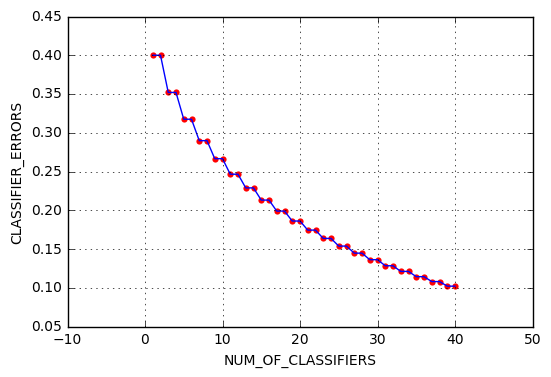

In [233]:
base_error = 0.4
plot_num_classifier(better_ensemble_error2, 
                    max_num_classifier=max_num_classifiers, 
                    base_error=base_error)

In [234]:
base_error = 0.6

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


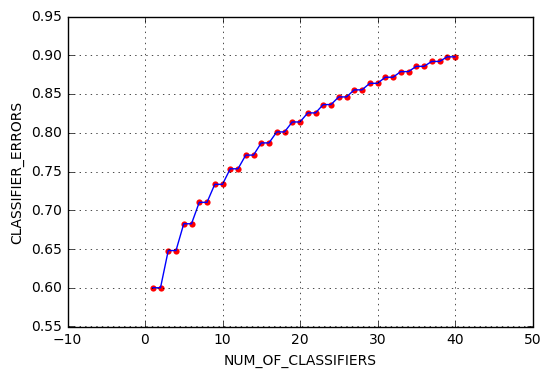

In [235]:
plot_num_classifier(better_ensemble_error2, 
                    max_num_classifier=max_num_classifiers, 
                    base_error=base_error)

#### Third way: Consider threshold & choose optimal number of classifiers among maximum number:

In [236]:
def better_ensemble_error3(num_classifier, base_error):
    #If the base_error>=0.5, we use only one classifier to avoid increasing the ensemble_error.
    #We traverse different number of classifiers to get optimal number of classifiers.
    classifiers = [i+1 for i in range(num_classifier)]
    ensemble_errors = [better_ensemble_error(num, base_error) for num in classifiers]
    min_error, min_error_index = min(ensemble_errors), np.argmin(min(ensemble_errors))+1
    #print("The minimum error produced by ensemble in range 1->num_classifier is %.3f,corresponding number is %d" %(min_error, min_error_index))
    return min_error

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


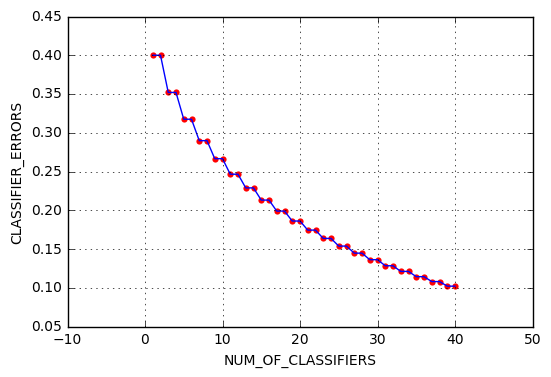

In [237]:
base_error = 0.4
plot_num_classifier(better_ensemble_error3, 
                    max_num_classifier=max_num_classifiers, 
                    base_error=base_error)

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


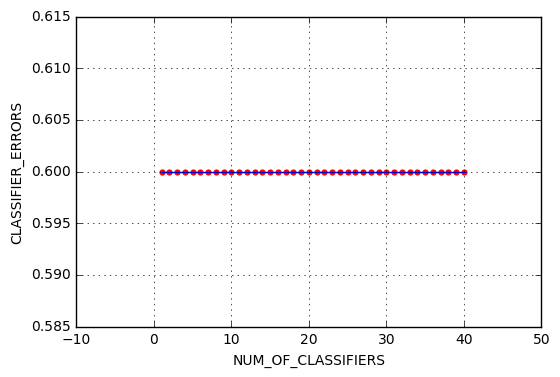

In [238]:
base_error = 0.6
plot_num_classifier(better_ensemble_error3, 
                    max_num_classifier=max_num_classifiers, 
                    base_error=base_error)